In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Installing necessary libraries

In [2]:
!pip install -U transformers
!pip install datasets
!pip install sentencepiece
!pip install jiwer
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 116.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 85.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 78.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [3]:
!pip install --upgrade datasets


In [4]:
# For calculating WER (Word Error Rate)
! pip install jiwer

In [5]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00


# Login credentials for Hugging Face

In [6]:
from huggingface_hub import login
login(token='YOUR_TOKEN_HERE')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **1. Data Preparation**
- **Task**: Load and preprocess the dataset.
- **Process**:
  1. **Dataset Loading**: The dataset is loaded from Hugging Face (`SKNahin/bengali-transliteration-data`) using the `load_dataset` function.
  2. **Splitting**: The dataset is split into training and testing subsets with an 80:20 ratio to ensure the model generalizes well.


  - **Justification**:
    - The 80:20 split ensures sufficient data for both training and evaluation.
    - Hugging Face's `datasets` library simplifies data handling and supports preprocessing pipelines.

---


In [8]:
from datasets import load_dataset

ds = load_dataset("SKNahin/bengali-transliteration-data")

README.md:   0%|          | 0.00/300 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/333k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5006 [00:00<?, ? examples/s]

In [9]:
# Split the dataset into 80% train and 20% test
split_ds = ds["train"].train_test_split(test_size=0.2, seed=42)

# Convert to Pandas DataFrames (if required)
train_df = split_ds["train"].to_pandas()
test_df = split_ds["test"].to_pandas()

# Check the splits
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 4004
Test set size: 1002


In [10]:
train_df.head()

,bn,rm
0,এটা কোনো পোস্ট হলো মিয়া আবাল,eta kono post holo mia abal
1,ডিলিট করেন পোস্ট…,Delete koren post…
2,জি ভাই অসাধারণ হইছে বাট ফুল ডিটেইলস জানতে পারল...,ji bai osadaron hoice but full detailes janty ...
3,ভাই...আর ২৪ আওয়ার ওয়েট করেন..আমার এফবি আইডি ব্...,vai…ar 24 hour wait koren..amar fb id back ash...
4,এক সাথে কয়টা একাউন্ট লগইন করে রাখা যায় ব্রো?,Ak sathe koyta account login kre rakha jay bro?


In [11]:
train_df.head()

,bn,rm
0,এটা কোনো পোস্ট হলো মিয়া আবাল,eta kono post holo mia abal
1,ডিলিট করেন পোস্ট…,Delete koren post…
2,জি ভাই অসাধারণ হইছে বাট ফুল ডিটেইলস জানতে পারল...,ji bai osadaron hoice but full detailes janty ...
3,ভাই...আর ২৪ আওয়ার ওয়েট করেন..আমার এফবি আইডি ব্...,vai…ar 24 hour wait koren..amar fb id back ash...
4,এক সাথে কয়টা একাউন্ট লগইন করে রাখা যায় ব্রো?,Ak sathe koyta account login kre rakha jay bro?


In [12]:
test_df.head()

,bn,rm
0,ভালো করে ট্রাই করেন পাবেন..,valo kore trai koren paben..
1,এতো বানান ভুল করছেন বারে,Eto banan vul krcen bare
2,যা শুরু করছেন ভাই?,ja suru korcen vai?
3,মাশাল্লাহ অনেক সুন্দর পোষ্ট।,masallha onak sundor post.
4,এতো কিছুর দরকার হয় না… জাস্ট মডিউল ফ্ল্যাশ ইজ ...,eto kisur dorkar hoy nah… just module flash is...



# **2. Data Preprocessing**
- **Task**: Tokenize and clean the data.
- **Process**:
  1. **Removing Null or Corrupted Entries**: Null or empty rows are filtered out to avoid errors during training.
  2. **Tokenization**: Both Banglish (input) and Bengali (output) text are tokenized using the UMT5-Base tokenizer.

  

  - **Justification**:
    - The UMT5 tokenizer aligns perfectly with the pretrained UMT5-Base model, ensuring consistent input-output transformations.
    .

---

In [13]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [14]:
print("Total number of training samples:", len(train_df))
print("Total number of test samples:", len(test_df))

Total number of training samples: 4004
Total number of test samples: 1002


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


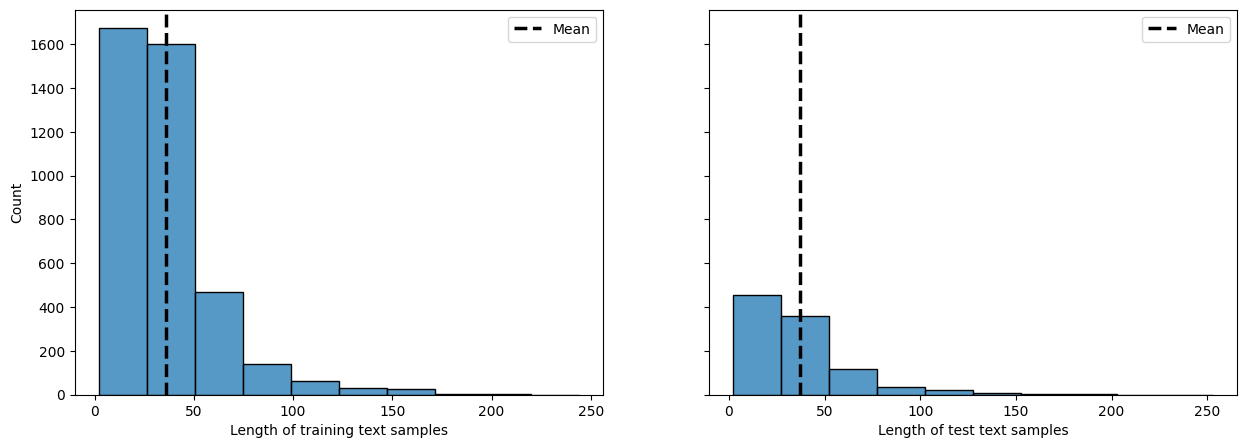

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

train_lengths = train_df["rm"].str.len()
sns.histplot(ax=axes[0], data=train_lengths, bins=10).set(xlabel="Length of training text samples")
axes[0].axvline(train_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
axes[0].legend()

test_lengths = test_df["rm"].str.len()
sns.histplot(ax=axes[1], data=test_lengths, bins=10).set(xlabel="Length of test text samples")
axes[1].axvline(test_lengths.mean(), c="k", ls="--", lw=2.5, label="Mean")
axes[1].legend()


plt.show()

In [16]:
import re

train_corpus = train_df["rm"].sum()
test_corpus = test_df["rm"].sum()

# Remove punctuations
chars_to_ignore = '[-,\.:;\'"!\?।]'

train_corpus = re.sub(chars_to_ignore, ' ', train_corpus)
train_vocab = set(train_corpus.split())

test_corpus = re.sub(chars_to_ignore, ' ', test_corpus)
test_vocab = set(test_corpus.split())

oov = test_vocab - train_vocab

print("Number of unique words in training data:", len(train_vocab))
print("Number of unique words in test data:", len(test_vocab))
print("Number of out-of-vocabulary (OOV) words:", len(oov))

Number of unique words in training data: 7471
Number of unique words in test data: 2722
Number of out-of-vocabulary (OOV) words: 1309


In [17]:
# Filtering text samples that contain English alphanumeric values
filtered_train = train_df[lambda x: x["rm"].str.contains("[A-Za-z0-9]")]

with pd.option_context('display.max_colwidth', 0):
    display(filtered_train.tail(n=10))

,bn,rm
3994,কিছু বলার ইচ্ছা নাই,kisu bolar iccha nai
3995,ধন্যবাদ ভাইজান,dhonnobad vaijan
3996,এই লিংক এর অ্যাপ টায় আমার ফোন ভাইরাস ডিটেক্ট করছে,ai link er app tay amar phone virus detect korche
3997,টেলিগ্রাম এ অ্যাড হলে সবআপডেট পাবেন,telegram a add hole sobupdate paben
3998,একেবারে সুন্দর খাটি কয়েকটা কথা লিখেছেন ভাই,ekebare shundor khati koyekta kotha likhechen vai
3999,ভাইয়া নেক্সট পোস্ট প্লিজ,vaia next post Please
4000,"ভাই,, এইটা সকল আপডেট (জে2 বা এর থেকে নিউ) স্যামসাং মোবাইল এই এই অপশনস আছে...","Vai,, Eita Sokol Update (J2 ba er theke new) Samsung mobile ei ei options ace…"
4001,এরকম আরো চাই ভাই…,Erokom aro chai vai…
4002,চেঞ্জ করার কথা বলা হয়নি,Change korar kotha bola hoini
4003,"আচ্ছা বাপ্পি ব্রো তোমার তামিল,তেলুগু,কান্নাডা, মালায়াম ফিল্ম এ ফেভারেট হিরো কারা","Accha bappi bro tumar tamil,Telugu,Kannada, malayam film e favourite hero kara"


In [18]:
bangla_numerals = "[০১২৩৪৫৬৭৮৯]"

filtered_train = train_df[lambda x: x["rm"].str.contains(bangla_numerals)]
filtered_test = test_df[lambda x: x["rm"].str.contains(bangla_numerals)]

print("Number of training samples containing Bangla numerals:", len(filtered_train))
print("Number of test samples containing Bangla numerals:", len(filtered_test))

Number of training samples containing Bangla numerals: 2
Number of test samples containing Bangla numerals: 0


In [19]:
train_df.head()

,bn,rm
0,এটা কোনো পোস্ট হলো মিয়া আবাল,eta kono post holo mia abal
1,ডিলিট করেন পোস্ট…,Delete koren post…
2,জি ভাই অসাধারণ হইছে বাট ফুল ডিটেইলস জানতে পারল...,ji bai osadaron hoice but full detailes janty ...
3,ভাই...আর ২৪ আওয়ার ওয়েট করেন..আমার এফবি আইডি ব্...,vai…ar 24 hour wait koren..amar fb id back ash...
4,এক সাথে কয়টা একাউন্ট লগইন করে রাখা যায় ব্রো?,Ak sathe koyta account login kre rakha jay bro?


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.001, shuffle=True, random_state=3000)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [21]:
from datasets import Dataset

ds_train = Dataset.from_pandas(train_df)
ds_eval = Dataset.from_pandas(val_df)

# **3. Model Selection**
- **Task**: Choose a suitable model for transliteration.
- **Choice**: `google/umt5-base`
- **Justification**:
  - **Performance**:
    - UMT5 is a multilingual model designed for sequence-to-sequence tasks like translation and transliteration.
    - It has shown robust performance on low-resource languages.
  - **Suitability**:
    - UMT5 supports Bengali and Roman script, making it ideal for Banglish-to-Bengali transliteration.
  - **Efficiency**:
    - The model is lightweight compared to larger models like mT5-Large or mBART, making it suitable for faster training and inference without sacrificing accuracy.

---

In [22]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model_id_pretrained = "google/umt5-base"
tokenizer = AutoTokenizer.from_pretrained(model_id_pretrained)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id_pretrained,dropout_rate= 0.2)
data_collator = DataCollatorForSeq2Seq(tokenizer)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/6.84k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.55M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/6.62k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.37G [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [23]:
model.config

UMT5Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/umt5-base",
  "architectures": [
    "UMT5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.2,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "umt5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "scalable_attention": true,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.47.1",
  "use_cache": true,
  "vocab_size": 256384
}

In [24]:
def prepare_dataset(sample):
    output = tokenizer(sample["rm"])
    output["labels"] = tokenizer(sample["bn"])['input_ids']
    output["length"] = len(output["labels"])
    #print(output)
    return output


ds_train = ds_train.map(prepare_dataset, remove_columns=ds_train.column_names)
ds_eval = ds_eval.map(prepare_dataset, remove_columns=ds_eval.column_names)

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [25]:
ds_train.features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'length': Value(dtype='int64', id=None)}

In [26]:
import numpy as np
import evaluate

wer_metric = evaluate.load("wer")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    

    if isinstance(preds, tuple):
        preds = preds[0]

    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = wer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"wer": result}

In [27]:
!rm -rf /kaggle/working/Elite_Enigmas/umt5_base_version1/checkpoint-4000


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [28]:

import os
import torch
torch.cuda.empty_cache() 
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"


# **4. Training the Model**
- **Task**: Fine-tune the UMT5-Base model on the processed dataset.
- **Setup**:
  1. Define training arguments.
  2. Use `Seq2SeqTrainer` for fine-tuning.
  3. Monitor metrics such as WER (Word Error Rate) during evaluation.


  - **Hyperparameter Justification**:
    - **Batch Sizes**: Small batch sizes (4 for training, 8 for evaluation) are chosen to handle memory constraints.
    - **Learning Rate**: `5e-4` is used for stable convergence.
    - **Epochs**: `15` epochs allow the model sufficient time to learn patterns.
    - **Weight Decay**: `1e-2` helps prevent overfitting.
    - **Metric**: WER is chosen as the primary evaluation metric for transliteration tasks.

---

In [29]:

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

model_id = "Elite_Enigmas/umt5_base_version1"

training_args = Seq2SeqTrainingArguments(
    output_dir=model_id,
    group_by_length=True,
    length_column_name="length",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    metric_for_best_model="wer",
    greater_is_better=False,
    load_best_model_at_end=True,
    num_train_epochs=15,
    save_steps=4000,
    eval_steps=4000,
    logging_steps=4000,
    learning_rate=5e-4,
    weight_decay=1e-2,
    warmup_steps=2000,
    save_total_limit=1,
    predict_with_generate=True,
    generation_max_length=128,
    push_to_hub=False,
    report_to="none",
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


<ipython-input-30-277c675b5e38>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Wer
4000,7.487100,2.031438,1.281250
8000,0.948700,1.073775,0.312500
12000,0.454700,1.096124,0.281250


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

TrainOutput(global_step=15000, training_loss=2.4299089884440104, metrics={'train_runtime': 3465.9311, 'train_samples_per_second': 17.307, 'train_steps_per_second': 4.328, 'total_flos': 2135342989974528.0, 'train_loss': 2.4299089884440104, 'epoch': 15.0})

In [31]:
trainer.save_model(model_id)

# Save Model to Hugging Face

In [32]:
kwargs = {
    "language": "bn",
    "model_name": f"Elite_Enigmas/{model_id_pretrained}",  # a 'pretty' name for your model
    "finetuned_from": f"{model_id_pretrained}",
    "tasks": "text2text-generation",
}

In [33]:
trainer.push_to_hub(**kwargs)

tokenizer.json:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.55M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.37G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.50k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Rufiiii/umt5_base_version1/commit/c0101dcc9de6926de29728577db5a37ab2c9e945', commit_message='End of training', commit_description='', oid='c0101dcc9de6926de29728577db5a37ab2c9e945', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [34]:
# Sort by length
index = test_df["rm"].str.len().sort_values(ascending=False).index
test_df = test_df.reindex(index)

In [35]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model=model_id, device=0)

Device set to use cuda:0


In [36]:
%%time
texts = test_df["rm"].tolist()
bns = pipe(texts, max_length=128, batch_size=64)
bns = [bn["generated_text"] for bn in bns]

CPU times: user 15.1 s, sys: 6.78 ms, total: 15.1 s
Wall time: 15.1 s


In [37]:
test_df["bn"] = bns
test_df = test_df.sort_index()
test_df.head()

,bn,rm
0,ভালো করে ট্রাই করেন পাবেন..,valo kore trai koren paben..
1,এতো বানান ভুল করছেন বারে,Eto banan vul krcen bare
2,যা শুরু করছেন ভাই?,ja suru korcen vai?
3,মারাত্মা অনেক সুন্দর পোস্ট।,masallha onak sundor post.
4,এতো কিছুর দরকার হয় না… জাস্ট সিম্যাম ফ্ল্যাশ ই...,eto kisur dorkar hoy nah… just module flash is...


In [38]:
test_df.to_csv("submission_final.csv", columns=["bn"], index=False)

In [39]:

df = pd.read_csv('submission_final.csv',  lineterminator='\n')


# Check if there's any unnamed column
unnamed_columns = [col for col in df.columns if 'Unnamed' in col]

if unnamed_columns:
    # Rename the first unnamed column to a desired name
    new_name = 'id'  # Specify your desired name here
    old_name = unnamed_columns[0]
    df.rename(columns={old_name: new_name}, inplace=True)


# Display the DataFrame after renaming the columns
print("\nDataFrame after renaming columns:")
df.rename(columns={'bn': 'string'}, inplace=True)
print(df)
df.to_csv('submission_final.csv', index=False)


DataFrame after renaming columns:
                                                 string
0                           ভালো করে ট্রাই করেন পাবেন..
1                              এতো বানান ভুল করছেন বারে
2                                    যা শুরু করছেন ভাই?
3                           মারাত্মা অনেক সুন্দর পোস্ট।
4     এতো কিছুর দরকার হয় না… জাস্ট সিম্যাম ফ্ল্যাশ ই...
...                                                 ...
997                           ভাই কাজ কেম পাচ্ছেন না ??
998                     আপনি গুগল দেখেন ওল্ড ভার্সন আছে
999                   রেফার হ্যাক করলে রেফার অ্যাড হবে?
1000        আপনি যদি ভিডিও দেখেউ ডাউনলোড লিংক আনলক করতে
1001  আপনার ফোনের স্টোরেজ কমেন্টে ১ জিবি ফ্যাকটা থাক...

[1002 rows x 1 columns]


In [40]:
import pandas as pd

# Load your CSV file into a DataFrame
df = pd.read_csv('submission_final.csv')

# Add a new column 'id' based on the 'string' column
df.insert(0, 'id', range(len(df)))

# Save the updated DataFrame back to a new CSV file
df.to_csv('submission_final.csv', index=False)
